Agnieszka Wrzos

### Opis zbioru danych
Dane:
- artists.csv - informacje o zbiorze danych
- resized.zip - obrazy 50ciu różnych artystów

Źródło: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/data




# Budowa modelu 2

## Wczytanie bibliotek

In [1]:
# Operacje matematyczne i macierzowe
import numpy as np
from numpy.random import seed

# Manipulacja i analiza danych
import pandas as pd

# Generowanie liczb losowych
import random

# Praca z danymi w formacie JSON
import json

# Operacje na systemie plików i ścieżkach
import os
import shutil

# Pasek postępu
from tqdm import tqdm, tqdm_notebook

# Wizualizacja danych
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
# Podział danych na zbiory treningowe i testowe
from sklearn.model_selection import train_test_split

# Ocena wyników modelu
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow i Keras - Tworzenie i trenowanie modeli głębokiego uczenia
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers, applications, optimizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Ustawienie losowości
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# Wczytanie danych i EDA

In [3]:
# Wczytanie danych
dane = pd.read_csv('data//artists.csv')

In [4]:
# Wymiary tabeli danych
dane.shape

(50, 8)

In [5]:
dane

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


Wnioski:
Dane zawierają informacje o 50ciu artystach:


Problemy:
- Niezbalansowane dane. Więcej niż 200 obrazów tylko 11 artystów.

# Model 2

In [4]:
# Funkcja do tworzenia zbiorów danych na podstawie minimalnej liczby obrazów
def create_datasets(min_images, data_dir, train_dir, val_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for artist in os.listdir(data_dir):
        artist_dir = os.path.join(data_dir, artist)
        if os.path.isdir(artist_dir):
            images = os.listdir(artist_dir)
            if len(images) >= min_images:
                image_paths = [os.path.join(artist_dir, img) for img in images]
                
                # Podział danych w proporcji 80:20
                train_images, val_images = train_test_split(image_paths, test_size=0.2, random_state=42)
                
                # Tworzenie folderów dla artystów w zbiorze treningowym i walidacyjnym
                os.makedirs(os.path.join(train_dir, artist), exist_ok=True)
                os.makedirs(os.path.join(val_dir, artist), exist_ok=True)
                
                # Przenoszenie obrazów do odpowiednich folderów
                for image in train_images:
                    shutil.copy(image, os.path.join(train_dir, artist, os.path.basename(image)))
                for image in val_images:
                    shutil.copy(image, os.path.join(val_dir, artist, os.path.basename(image)))

# Ustawienia ścieżek
base_data_dir = 'data/images/images'
base_train_dir = 'data/images/train_augmentedcut'
base_val_dir = 'data/images/val_augmentedcut'



In [5]:
# Tworzenie i trenowanie modeli dla różnych minimalnych liczby obrazów

min_images_list = [100, 200, 300]
history_dict = {}

for min_images in min_images_list:
    # Ścieżki dla bieżącego zestawu danych
    train_dir = f'{base_train_dir}_{min_images}'
    val_dir = f'{base_val_dir}_{min_images}'
    
    # Tworzenie zestawów danych
    create_datasets(min_images, base_data_dir, train_dir, val_dir)
    
    # Augmentacja zbioru treningowego
    train_data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Data generator bez augmentacji dla walidacji
    val_data_gen = ImageDataGenerator(rescale=1./255)
    
    # Wczytywanie danych treningowych
    train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
    )
    
    # Wczytywanie danych walidacyjnych
    validation_generator = val_data_gen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical'
    )
    
    # Sprawdzenie liczby klas
    num_classes = len(train_generator.class_indices)
    print(f"Liczba klas (min_images={min_images}):", num_classes)
    
    # Budowanie modelu
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Kompilacja modelu
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Trenowanie modelu
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator
    )
    
    # Przechowywanie historii treningu
    history_dict[min_images] = history

    print(f"Model z minimalną liczbą obrazów {min_images} został wytrenowany.")

# `history_dict` - wyniki modeli


Found 5659 images belonging to 30 classes.
Found 1432 images belonging to 30 classes.
Liczba klas (min_images=100): 30


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.1079 - loss: 12.2511 - val_accuracy: 0.0552 - val_loss: 7.3958
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.1182 - loss: 4.4696 - val_accuracy: 0.1020 - val_loss: 4.0231
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.1413 - loss: 3.7972 - val_accuracy: 0.1620 - val_loss: 3.5774
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.1479 - loss: 3.5606 - val_accuracy: 0.0845 - val_loss: 4.5302
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.1418 - loss: 3.5284 - val_accuracy: 0.1858 - val_loss: 3.2858
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.1692 - loss: 3.2857 - val_accuracy: 0.1948 - val_loss: 4.3571
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.1858 - loss: 3.2207 - val_accuracy: 0.1641 - val_loss: 4.0179
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.2250 - loss: 3.0272 - val_accuracy: 0.18

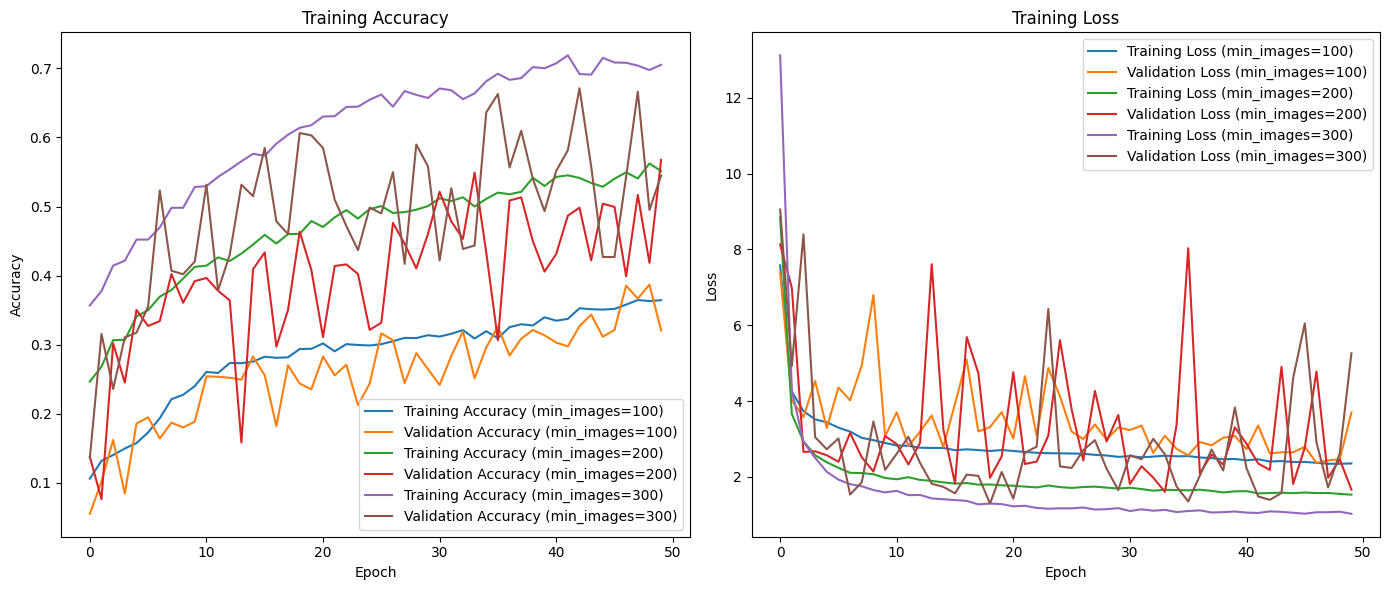

In [10]:
def plot_training_curves(history_dict):
    plt.figure(figsize=(14, 6))

    for min_images, history in history_dict.items():
        # Wykres dokładności
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label=f'Training Accuracy (min_images={min_images})')
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy (min_images={min_images})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        # Wykres strat
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label=f'Training Loss (min_images={min_images})')
        plt.plot(history.history['val_loss'], label=f'Validation Loss (min_images={min_images})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Rysowanie wykresów strat i dokładności
plot_training_curves(history_dict)


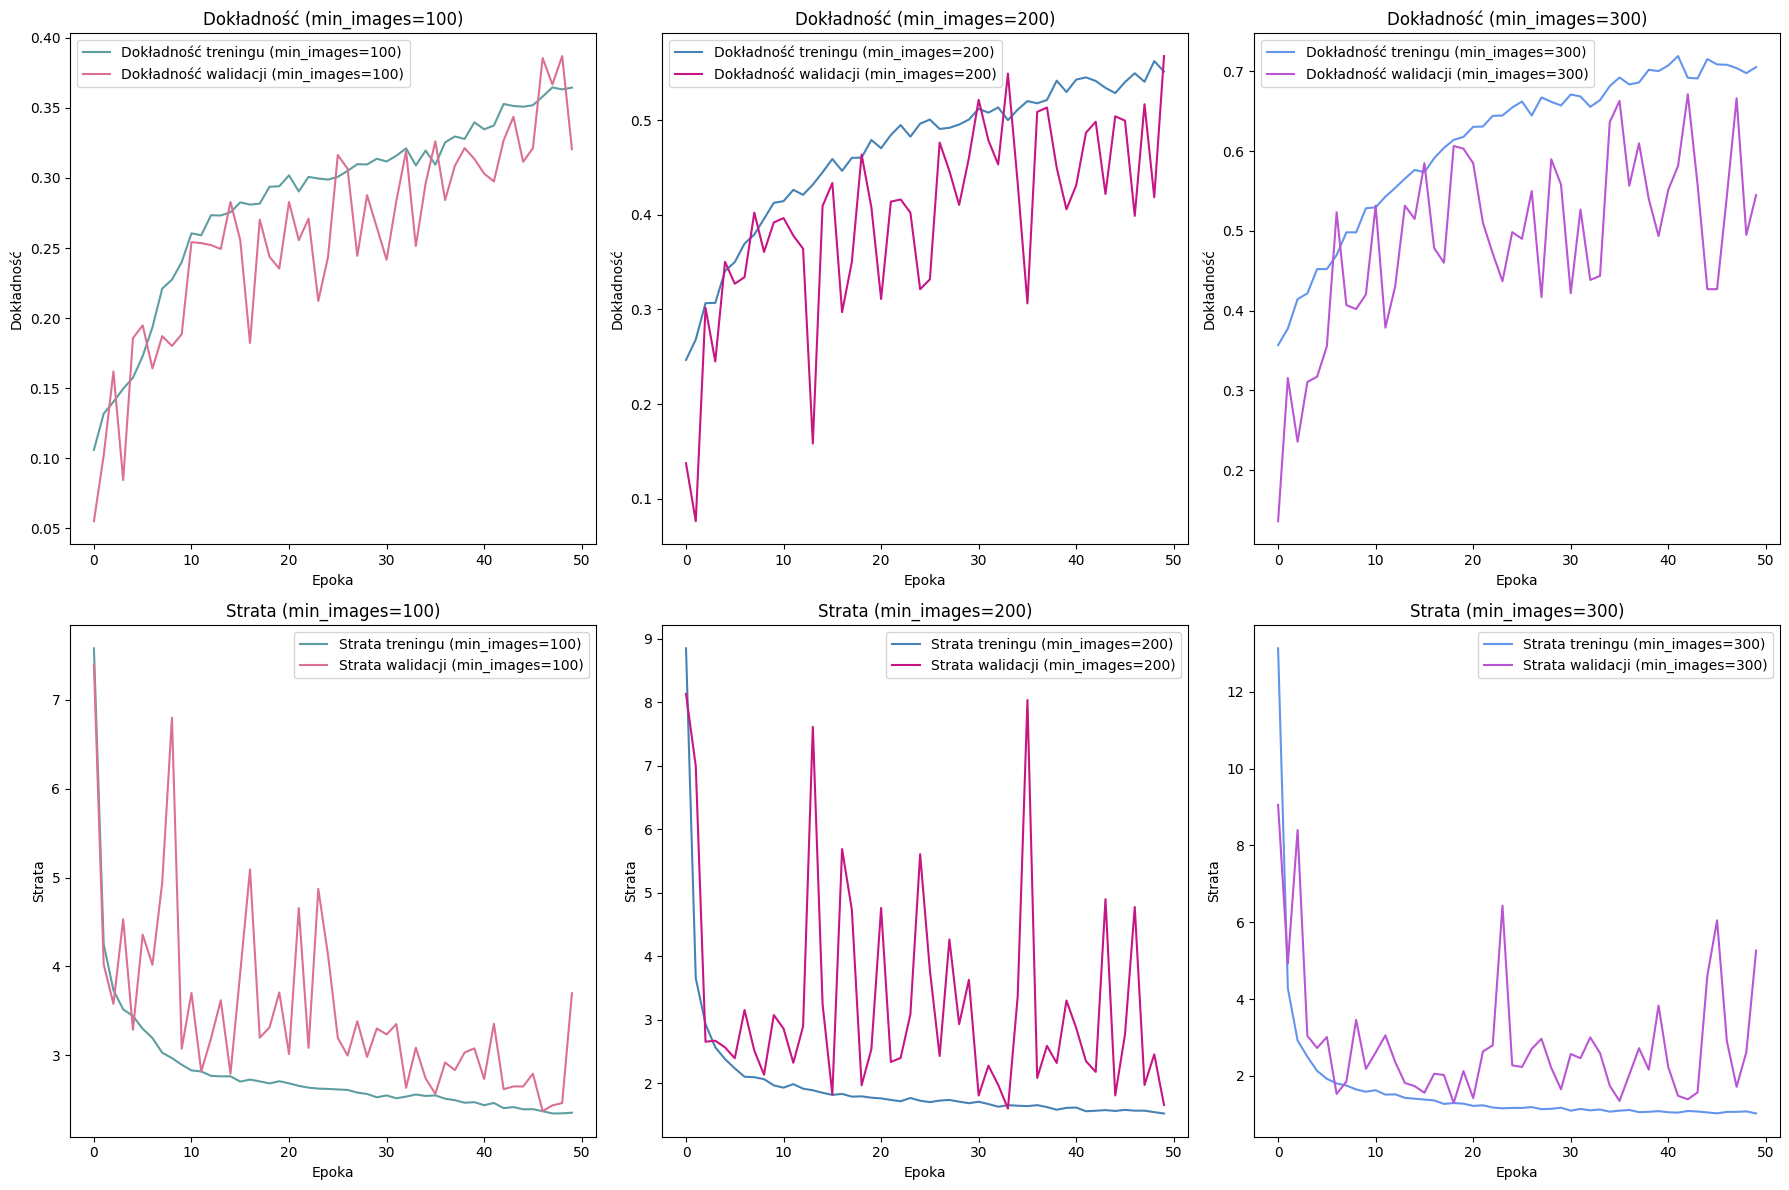

In [21]:
import matplotlib.pyplot as plt

def plot_training_curves(history_dict):
    plt.figure(figsize=(18, 12))  # Większy rozmiar dla sześciu wykresów

    # Zestawy pastelowych kolorów dla każdej grupy wykresów
    color_sets = [
        {'train': '#5F9EA0', 'val': '#DB7093'},   
        {'train': '#4682B4', 'val': '#C71585'}, 
        {'train': '#6495ED', 'val': '#BA55D3'} 
    ]

    # Wykres 1-3: Dokładność treningu i walidacji
    for i, (min_images, history) in enumerate(history_dict.items()):
        color_set = color_sets[i]  # Pobieramy odpowiedni zestaw kolorów dla każdej pary

        # Wykres dokładności (pierwszy rząd)
        plt.subplot(2, 3, i + 1)  # Pierwszy rząd (Dokładność)
        plt.plot(history.history['accuracy'], label=f'Dokładność treningu (min_images={min_images})', color=color_set['train'])
        plt.plot(history.history['val_accuracy'], label=f'Dokładność walidacji (min_images={min_images})', color=color_set['val'])
        plt.xlabel('Epoka')
        plt.ylabel('Dokładność')
        plt.title(f'Dokładność (min_images={min_images})')
        plt.legend()

    # Wykres 4-6: Strata treningu i walidacji
    for i, (min_images, history) in enumerate(history_dict.items()):
        color_set = color_sets[i]  # Pobieramy odpowiedni zestaw kolorów dla każdej pary

        # Wykres strat (drugi rząd)
        plt.subplot(2, 3, i + 4)  # Drugi rząd (Strata)
        plt.plot(history.history['loss'], label=f'Strata treningu (min_images={min_images})', color=color_set['train'])
        plt.plot(history.history['val_loss'], label=f'Strata walidacji (min_images={min_images})', color=color_set['val'])
        plt.xlabel('Epoka')
        plt.ylabel('Strata')
        plt.title(f'Strata (min_images={min_images})')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Przykładowe wywołanie z history_dict zawierającym dane dla 100, 200, 300 obrazów:
plot_training_curves(history_dict)
